# Topics

- Graphs
- Networks
- Queue
- The least common multiple (LCM) 

In [1]:
import numpy as np
import pandas as pd
import math
import re
import sys
from shapely.geometry import Polygon
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict, namedtuple, defaultdict, ChainMap
from queue import Queue
from copy import deepcopy
from functools import cmp_to_key
from itertools import product, permutations, combinations, combinations_with_replacement
from itertools import repeat
from functools import cache
import json

In [2]:
sys.setrecursionlimit(1500)

In [3]:
with open("20-input", "r") as file:
    lines = file.readlines()
data_raw = [line.replace("\n", "") for line in lines]
data_raw = "\n".join(data_raw)
data_raw

'&pr -> pd, vx, vn, cl, hm\n%hm -> qb\n%nm -> dh, jv\n%lv -> jv, tg\n%dg -> tm, jm\n%mt -> jv, zp\n&ln -> kj\n&kj -> rx\n&dr -> kj\n%dx -> ts\n&qs -> kf, dr, sc, rg, gl, dx\n%dh -> jv, mc\n%rg -> qs, vq\n%kt -> jv, mt\n%lh -> qs, dl\n%tp -> pf, jm\n%bf -> vx, pr\n%mv -> qs, gl\n%ts -> ng, qs\n%kf -> dx\n%gv -> jm, km\n%dl -> qs\n%nd -> dg\n%km -> jm\n%ns -> pr, pn\n%gl -> kf\n%pd -> pr, jp\n%xv -> nd, jm\n%hf -> nm\n%vx -> ns\n%vq -> bs, qs\n%sc -> mv\n&jv -> hj, rc, kt, ln, zp, hf\n%rc -> hj\n%jp -> mx, pr\n%mf -> gv, jm\n&zx -> kj\n%tg -> jv\n%bs -> sc, qs\n%ng -> qs, lh\n%tk -> pr\n%qb -> bf, pr\n%pn -> pr, cb\n%cl -> hm\n%pb -> tp\nbroadcaster -> kt, pd, xv, rg\n&jm -> pb, tm, zx, mk, xv, nd\n%vc -> jv, hf\n%mc -> jv, lv\n%mk -> pb\n%tm -> mh\n%cb -> pr, tk\n%hj -> vc\n%zp -> rc\n%mh -> mk, jm\n%pf -> mf, jm\n%mx -> cl, pr\n&vn -> kj'

In [4]:
test_data_raw = r"""broadcaster -> a, b, c
%a -> b
%b -> c
%c -> inv
&inv -> a"""

test_data_raw2 = r"""broadcaster -> a
%a -> inv, con
&inv -> b
%b -> con
&con -> output"""


Step = namedtuple("Step", ["direction", "number", "color"])
def preprocess_data (data):
    # dtype='U10'

    def parse_module(module):
        mod, dest = module.split(" -> ")[0], module.split(" -> ")[1]
        dest = dest.split(", ")
        module_dict = {}
        if mod.startswith("%"):
            module_dict[mod.split("%")[1]] = {"type": "%", "destinations": dest, "memory": 0}
        elif mod.startswith("&"):
            module_dict[mod.split("&")[1]] = {"type": "&", "destinations": dest}
        else:
            module_dict[mod] = {"type": "", "destinations": dest}
        return module_dict

    modules = [parse_module(module_str) for module_str in data.split("\n")]
    modules = dict(ChainMap(*modules))

    for mod, info in modules.items():
        if info["type"] == "&":
            connected_mods = [ _mod   for _mod, _info in modules.items()  if mod in _info["destinations"]]
            info["memory"] = {_mod: 0 for _mod in connected_mods}

    # rows = [row.split(" ") for row in data.split("\n")]
    # steps = [Step(direction, int(num), color.split("(")[1].split(")")[0]) for direction, num, color in rows]
    return modules

test_data = preprocess_data(test_data_raw)
display(test_data)
test_data2 = preprocess_data(test_data_raw2)
test_data2

{'inv': {'type': '&', 'destinations': ['a'], 'memory': {'c': 0}},
 'c': {'type': '%', 'destinations': ['inv'], 'memory': 0},
 'b': {'type': '%', 'destinations': ['c'], 'memory': 0},
 'a': {'type': '%', 'destinations': ['b'], 'memory': 0},
 'broadcaster': {'type': '', 'destinations': ['a', 'b', 'c']}}

{'con': {'type': '&', 'destinations': ['output'], 'memory': {'b': 0, 'a': 0}},
 'b': {'type': '%', 'destinations': ['con'], 'memory': 0},
 'inv': {'type': '&', 'destinations': ['b'], 'memory': {'a': 0}},
 'a': {'type': '%', 'destinations': ['inv', 'con'], 'memory': 0},
 'broadcaster': {'type': '', 'destinations': ['a']}}

In [5]:
data = preprocess_data(data_raw)
data

{'vn': {'type': '&', 'destinations': ['kj'], 'memory': {'pr': 0}},
 'mx': {'type': '%', 'destinations': ['cl', 'pr'], 'memory': 0},
 'pf': {'type': '%', 'destinations': ['mf', 'jm'], 'memory': 0},
 'mh': {'type': '%', 'destinations': ['mk', 'jm'], 'memory': 0},
 'zp': {'type': '%', 'destinations': ['rc'], 'memory': 0},
 'hj': {'type': '%', 'destinations': ['vc'], 'memory': 0},
 'cb': {'type': '%', 'destinations': ['pr', 'tk'], 'memory': 0},
 'tm': {'type': '%', 'destinations': ['mh'], 'memory': 0},
 'mk': {'type': '%', 'destinations': ['pb'], 'memory': 0},
 'mc': {'type': '%', 'destinations': ['jv', 'lv'], 'memory': 0},
 'vc': {'type': '%', 'destinations': ['jv', 'hf'], 'memory': 0},
 'jm': {'type': '&',
  'destinations': ['pb', 'tm', 'zx', 'mk', 'xv', 'nd'],
  'memory': {'pf': 0,
   'mh': 0,
   'mf': 0,
   'xv': 0,
   'km': 0,
   'gv': 0,
   'tp': 0,
   'dg': 0}},
 'broadcaster': {'type': '', 'destinations': ['kt', 'pd', 'xv', 'rg']},
 'pb': {'type': '%', 'destinations': ['tp'], 'memo

In [60]:
def solution (data, verbose=False):
    

    def button_push(modules):
        
        q = Queue()
        num_low_pulses = 1
        num_high_pulses = 0
        for dest in  modules["broadcaster"]["destinations"]:
            if verbose:
                print("queing", dest, 0 , "broadcaster")
            q.put((dest, 0, "broadcaster"))
            num_low_pulses += 1

        while not q.empty():
            mod, pulse, source = q.get()
            if verbose:
                print("dequeing",  mod, pulse, source)
            if mod not in modules:
                continue
            info = modules[mod]
            mod_type = info["type"]
            pulse_next = 0
            if mod_type == "":
                pulse_next = pulse
            elif mod_type == "%":
                if pulse == 0:
                    pulse_next = 1 if info["memory"] == 0 else 0
                    info["memory"] = (info["memory"]+1) % 2
                else:
                    continue
            elif mod_type == "&":
                info["memory"][source] = pulse
                if sum(info["memory"].values()) == len(info["memory"].values()):
                    pulse_next = 0
                else:
                    pulse_next = 1
            
            for dest in info["destinations"]:
                if pulse_next == 0:
                    num_low_pulses += 1
                else:
                    num_high_pulses += 1
                if verbose:
                    # print("queing", dest, pulse_next, mod)
                    print(mod, pulse_next, "->", dest)
                q.put((dest, pulse_next, mod))



        
        return num_low_pulses, num_high_pulses
        
    total_low = 0
    total_high = 0
    modules = deepcopy(data)
    
    for i in range(1000):
        low, high = button_push(modules)
        total_low += low
        total_high += high

    return total_low, total_high



sol = solution(data)
# sol = solution(test_data, verbose=False)
# sol = solution(test_data2, verbose=False)

print(sol)
print(sol[0]*sol[1])
# display(sum(sol))


(18691, 50814)
949764474


# Part 2

In [109]:
def solution (data, verbose=False):
    
    def button_push(data):
        modules = data
        # for key, val in modules.items():
        #     if val["type"] == '&':
        #         print(key, val["memory"])
        q = Queue()

        nodes_of_interest = {"pr":"vn", "jm":"zx", "qs":"dr", "jv":"ln"}
        low_pulses = {key:0 for key in nodes_of_interest.keys()}

        for dest in  modules["broadcaster"]["destinations"]:
            if verbose:
                print("queing", dest, 0 , "broadcaster")
            q.put((dest, 0, "broadcaster"))

        while not q.empty():
            mod, pulse, source = q.get()
            if (source in nodes_of_interest.keys()) and (mod == nodes_of_interest[source])  and (pulse == 0):
                low_pulses[source] = 1
            if verbose:
                print("dequeing",  mod, pulse, source)
            if mod not in modules:
                continue
            info = modules[mod]
            mod_type = info["type"]
            pulse_next = 0
            if mod_type == "":
                pulse_next = pulse
            elif mod_type == "%":
                if pulse == 0:
                    pulse_next = 1 if info["memory"] == 0 else 0
                    info["memory"] = (info["memory"]+1) % 2
                else:
                    continue
            elif mod_type == "&":
                info["memory"][source] = pulse
                if sum(info["memory"].values()) == len(info["memory"].values()):
                    pulse_next = 0
                else:
                    pulse_next = 1
            
            for dest in info["destinations"]:
                if verbose:
                    # print("queing", dest, pulse_next, mod)
                    print(mod, pulse_next, "->", dest)

                if dest == "rx" and pulse_next==0:
                    print("Send", pulse_next, "to", dest)
                q.put((dest, pulse_next, mod))



        
        return modules, low_pulses
        
    modules = deepcopy(data)
    
    active = []
    for i in range(10000):
        # print("Iteration", i+1)
        modules, low_pulses = button_push(modules)
        if sum(low_pulses.values()) > 0:
            print(i+1, [(key, val) for key, val in low_pulses.items() if val > 0])

    return 0



sol = solution(data)
# sol = solution(test_data, verbose=False)
# sol = solution(test_data2, verbose=False)

print(sol)
# display(sum(sol))


3863 [('qs', 1)]
3943 [('pr', 1)]
3989 [('jm', 1)]
4003 [('jv', 1)]
7726 [('qs', 1)]
7886 [('pr', 1)]
7978 [('jm', 1)]
8006 [('jv', 1)]
0


- kj needs to send low to rx 
- that happens when ['vn', 'zx', 'dr', 'ln'] send 1 to kj
- this happens when ["pr", "jm", "qs", "jv"] send 0 to their respective targets
- qs: every 3863 buttonpresses
- pr: every 3943 buttonpresses
- jm: every 3989 buttonpresses
- jv: every 4003 buttonpresses
- use lcm again



In [110]:
numbers = [3863 , 3943 , 3989 , 4003]
numbers = np.array(numbers, dtype=np.int64)
np.lcm.reduce(numbers)

243221023462303

### Network drawing

c:\Users\Marc\anaconda3\envs\adventofcode\Lib\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


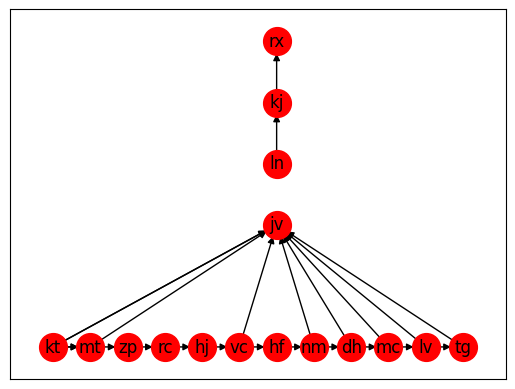

In [75]:
edges = []
for key in ["kt", 'dh', 'hf', 'hj', 'kt', 'lv', 'mc', 'mt', 'nm', 'rc', 'tg', 'vc', 'zp', "ln", "kj"]:
    edges = edges + [(key, dest) for dest in data[key]["destinations"]]



G = nx.DiGraph()
G.add_edges_from(edges)

val_map = {'A': 1.0,
           'D': 0.5714285714285714,
           'H': 0.0}

values = [val_map.get(node, 0.5) for node in G.nodes()]

pos = {key: (i, 0) for i, key in enumerate(['kt', 'mt', 'zp', 'rc', 'hj', 'vc', 'hf', 'nm', 'dh', 'mc', 'lv', 'tg'])}
pos["jv"] = (6,2)
pos["ln"] = (6,3)
pos["kj"] = (6,4)
pos["rx"] = (6,5)
# Specify the edges you want here
# red_edges = [('A', 'C'), ('E', 'C')]
# edge_colours = ['black' if not edge in red_edges else 'red'
#                 for edge in G.edges()]
# black_edges = [edge for edge in G.edges() if edge not in red_edges]

# Need to create a layout when doing
# separate calls to draw nodes and edges
# pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), 
                       node_color = "red", node_size = 400)
nx.draw_networkx_labels(G, pos)
# nx.draw_networkx_edges(G, pos, edgelist=red_edges, edge_color='r', arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=edges, arrows=True)
plt.show()